# Aperture Photometry with Python Photutils


## Overview

Extract aperture photometry for all our cluster stars and our standard star. 

In [1]:
# The standard fare:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io import fits 
import astropy.stats as stat
from astropy.stats import sigma_clip
from astropy.visualization import ZScaleInterval

from photutils.utils import calc_total_error
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, DAOStarFinder

In [2]:
# Load in the path and name of your B band stacked images.  It should not matter which band we use as all the bands are aligned to each other!  

datadir = datadir = '/Users/sarah/Documents/3GradSchool/TA/UT20191107/Stacked/'

clustername = 'IC5146'
standardname = 'FS150'

cluster_image_V  = datadir + clustername + '_Vstack.fits'
cluster_image_R  = datadir +clustername + '_Rstack.fits'
cluster_image_B  = datadir + clustername + '_Bstack.fits'

std_images_V = datadir + standardname + '_Vstack.fits'
# std_images_R = datadir + standardname + '_Rstack.fits'
std_images_B = datadir + standardname + '_Bstack.fits'


## 7.1 - Aperture Photometry on the Standard Star and your Cluster

In [3]:
from astropy.stats import mad_std
bkg_sigma = mad_std(fits.getdata(cluster_image_V))
print(bkg_sigma)

6.586552264159973


In [4]:
print(np.std(fits.getdata(cluster_image_V)))

138.08451551709686


In [5]:
def bg_error_estimate(fitsfile):
    """
    This function will calculate the noise in the background of our images 
    """
    fitsdata = fits.getdata(fitsfile)
    hdr = fits.getheader(fitsfile)
    
    # We are finding the amount of noise in our image
    filtered_data = sigma_clip(fitsdata, sigma=3.,copy=False)
    
    # We are calculating the median value of the noise
    bkg_values_nan = filtered_data.filled(fill_value=np.nan)
    bkg_error = np.sqrt(bkg_values_nan)
    bkg_error[np.isnan(bkg_error)] = np.nanmedian(bkg_error)
    
    effective_gain = 1.4 # electrons per ADU
    
    error_image = calc_total_error(fitsdata, bkg_error, effective_gain)  
    
    return error_image

In [6]:
# Star extraction function

#This function can be run as
# target_filter_xpos, target_filter_ypos = starExtractor("image.fit", nsigma_value=#, fwhm_value=#)

def starExtractor(fitsfile, nsigma_value, fwhm_value):
    """
    This function find all the stars in our image and gives the x and y position of the star. 
    """

    # Read in the data from the fits file 
    image = fits.getdata(fitsfile)
    
    # Measure the median absolute standard deviation of the image: We did it above, but copy and paste it below 
    bkg_sigma = mad_std(image)

    # Define the parameters for DAOStarFinder 
    daofind = DAOStarFinder(fwhm=fwhm_value, threshold=nsigma_value*bkg_sigma)
    
    # Apply DAOStarFinder to the image
    sources = daofind(image)
    nstars = len(sources)
    print("Number of stars found in ",fitsfile,":", nstars)
    
    # Define arrays of x-position and y-position
    xpos = np.array(sources['xcentroid'])
    ypos = np.array(sources['ycentroid'])
    
    return xpos, ypos # Return the x and y positions of each star as variables


In [7]:
# Photometry function, which returns a table of photometry values for a list of stars

# This function can be used as
# target_phot_table = measurePhotometry(file, star_xpos, star_ypos, aperture_radius, sky_inner, sky_outer, error_array)

def measurePhotometry(fitsfile, star_xpos, star_ypos, aperture_radius, sky_inner, sky_outer, error_array):
    """
    find the amount of flux from each star. 
    """
    # Read in the data from the fits file:
    image = fits.getdata(fitsfile)
    
    starapertures = CircularAperture((star_xpos, star_ypos),r = aperture_radius)
    skyannuli = CircularAnnulus((star_xpos, star_ypos), r_in = sky_inner, r_out = sky_outer)
    phot_apers = [starapertures, skyannuli]
    
    phot_table = aperture_photometry(image, phot_apers, error=error_array)
        
    # Calculate mean background in annulus and subtract from aperture flux
    bkg_mean = phot_table['aperture_sum_1'] / skyannuli.area()
    bkg_starap_sum = bkg_mean * starapertures.area()
    final_sum = phot_table['aperture_sum_0']-bkg_starap_sum
    phot_table['bg_subtracted_star_counts'] = final_sum
    
    bkg_mean_err = phot_table['aperture_sum_err_1'] / skyannuli.area()
    bkg_sum_err = bkg_mean_err * starapertures.area()

    phot_table['bg_sub_star_cts_err'] = np.sqrt((phot_table['aperture_sum_err_0']**2)+(bkg_sum_err**2)) 
    
    return phot_table


### Extracting photometry for the standard star images


In the cells below, we will complete the following steps for the reduced standard star V-band image:
* Measure the background of the image
* Extract the star positions 
* Use the star positions and background error to measure the photometry

In [8]:
# # Measure the background of the image
std_V_bgerror = bg_error_estimate(std_images_V)


In [9]:
# # Extract the star positions. Replace ?? with values for the extraction parameters that capture the stars of interest.
std_V_xpos, std_V_ypos = starExtractor(std_images_V, nsigma_value=10, fwhm_value=10)

Number of stars found in  /Users/sarah/Documents/3GradSchool/TA/UT20191107/Stacked/FS150_Vstack.fits : 1286


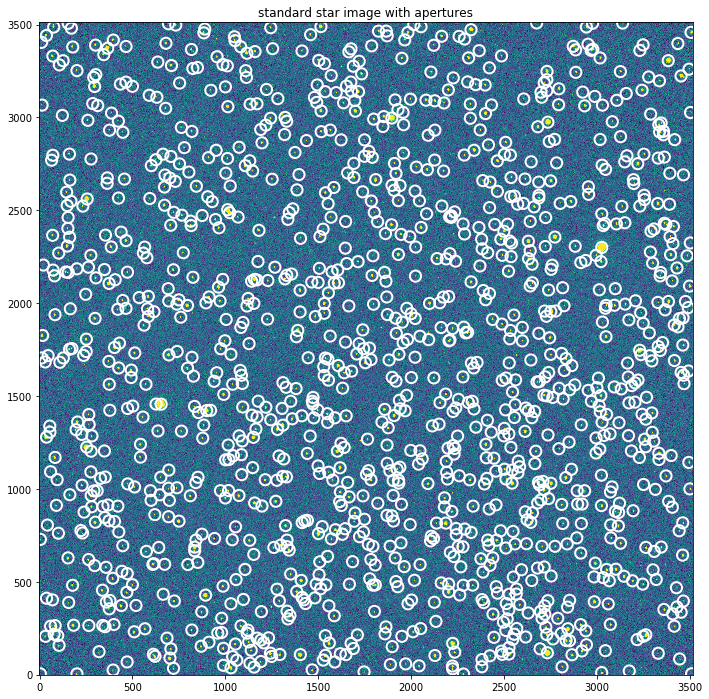

In [10]:
# # Plot your standard star and photometry.  

apertures = CircularAperture((std_V_xpos, std_V_ypos), r=30)
plt.figure(figsize=(12,12))
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(fits.getdata(std_images_V))
plt.imshow(fits.getdata(std_images_V), vmin=vmin,vmax=vmax, origin='lower')
apertures.plot(color='white', lw=2)
plt.title('standard star image with apertures')
plt.show()


In [11]:
# # Measure photometry for the V band image. Replace ?? with reasonable values
std_V_phottable = measurePhotometry(std_images_V, star_xpos=std_V_xpos, star_ypos=std_V_ypos, \
                                    aperture_radius=8, sky_inner=10, sky_outer=15, error_array=std_V_bgerror)


# R band

In [12]:
# # Measure the background of the R image
# # fill in the ?? with the R band standard image 
std_R_bgerror = bg_error_estimate(std_images_R)



NameError: name 'std_images_R' is not defined

In [ ]:
# # Measure photometry for the R band image. 
# # NOTE: Use std_V_xpos and std_V_ypos to extract photometry for the same stars in the same locations & order!
std_R_phottable = measurePhotometry(std_images_R, star_xpos=std_V_xpos, star_ypos=std_V_ypos, \
                                    aperture_radius=8, sky_inner=10, sky_outer=15, error_array=std_R_bgerror)






In [13]:
std_B_bgerror = bg_error_estimate(std_images_B)



In [14]:
std_B_phottable = measurePhotometry(std_images_B, star_xpos=std_V_xpos, star_ypos=std_V_ypos, \
                                    aperture_radius=8, sky_inner=10, sky_outer=15, error_array=std_B_bgerror)



We can now stitch together the results into a streamlined pandas dataframe, by defining the dataframe index and column labels of interest:

In [15]:
columns = ['id','xcenter', 'ycenter','Bflux','Bfluxerr', 'Vflux','Vfluxerr']#,'Rflux','Rfluxerr']

In [16]:
std_fluxtable = pd.DataFrame(
    {'id'      : std_V_phottable['id'],
     'xcenter' : std_V_phottable['xcenter'],
     'ycenter' : std_V_phottable['ycenter'],
     'Bflux'   : std_B_phottable['bg_subtracted_star_counts'],
     'Bfluxerr': std_B_phottable['bg_sub_star_cts_err'], 
     'Vflux'   : std_V_phottable['bg_subtracted_star_counts'],
     'Vfluxerr': std_V_phottable['bg_sub_star_cts_err']}, columns=columns)#
#      'Rflux'   : std_R_phottable['bg_subtracted_star_counts'],
#      'Rfluxerr': std_R_phottable['bg_sub_star_cts_err']}, columns=columns)

In [17]:
# # Below, check the dataframe to ensure that the combination worked:
std_fluxtable.head()

,id,xcenter,ycenter,Bflux,Bfluxerr,Vflux,Vfluxerr
0,1,4.442337,4.582707,2641.056077,107.440139,4761.489914,144.907309
1,2,2282.427748,3.814618,5664.485974,132.744885,10561.159004,177.714114
2,3,3510.510523,4.807557,2646.980448,107.620115,4830.134360,146.158138
3,4,201.434965,4.430381,3679.404841,129.481626,7527.556691,174.472295
4,5,3026.304213,11.324266,5091.585315,147.406491,13906.044033,206.445785


## **Extracting photometry for your cluster stars**

In the cells below, you will repeat the process with the actual cluster images V and R bands. Adjust the function inputs (e.g., star extraction) and the photometry parameters accordingly, and we will also estimate the combined errors in the final image and save these results as FITS files.

In the last cell, create a single pandas flux dataframe for the cluster image (`cluster_fluxtable`, just like the `std_fluxtable`). We will use these to calibrate the photometry in the next section.

In [ ]:
# Measure the background of the image
cluster_V_bgerror = bg_error_estimate(cluster_image_V)



In [ ]:
# Extract the star positions and save them to new variables. 
# Do you have too few stars? Too many? Check the quality of the extraction.
cluster_V_xpos, cluster_V_ypos = starExtractor(cluster_image_V, nsigma_value=10, fwhm_value=5)


In [ ]:
# Plot your standard star and photometry.  

apertures = CircularAperture((cluster_V_xpos, cluster_V_ypos), r=10)
plt.figure(figsize=(12,12))
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(fits.getdata(cluster_image_V))
plt.imshow(fits.getdata(cluster_image_V), vmin=vmin,vmax=vmax, origin='lower')
apertures.plot(color='red', lw=2)
plt.title('cluster star image with apertures')
plt.show()


In [ ]:
# Measure photometry 

cluster_V_phottable = measurePhotometry(cluster_image_V, star_xpos=cluster_V_xpos, star_ypos=cluster_V_ypos, \
                                    aperture_radius=8, sky_inner=10, sky_outer=15, error_array=cluster_V_bgerror)


In [ ]:
# Check the cluster photometry table
cluster_V_phottable

In [ ]:
# Follow the same approach for the the R band images, using the cluster B band star locations. 
# Add blank cells below as needed.

#fill in the ?? with the R band cluster 
cluster_R_bgerror = bg_error_estimate(cluster_image_R)





# fill in the ?? with the R band cluster
cluster_R_phottable = measurePhotometry(cluster_image_R, star_xpos=cluster_V_xpos, star_ypos=cluster_V_ypos, \
                                    aperture_radius=8, sky_inner=10, sky_outer=15, error_array=cluster_R_bgerror)




In [ ]:
cluster_B_bgerror = bg_error_estimate(cluster_image_B)





# fill in the ?? with the R band cluster
cluster_B_phottable = measurePhotometry(cluster_image_B, star_xpos=cluster_V_xpos, star_ypos=cluster_V_ypos, \
                                    aperture_radius=8, sky_inner=10, sky_outer=15, error_array=cluster_B_bgerror)



In [ ]:
columns = ['id','xcenter', 'ycenter','Bflux','Bfluxerr','Vflux','Vfluxerr','Rflux','Rfluxerr']

In [ ]:
# Finally, combine the photometry into a single pandas dataframe for your cluster. 

cluster_fluxtable = pd.DataFrame(
    {'id'      : cluster_V_phottable['id'],
     'xcenter' : cluster_V_phottable['xcenter'],
     'ycenter' : cluster_V_phottable['ycenter'],
     'Bflux'   : cluster_B_phottable['bg_subtracted_star_counts'],
     'Bfluxerr': cluster_B_phottable['bg_sub_star_cts_err'],
     'Vflux'   : cluster_V_phottable['bg_subtracted_star_counts'],
     'Vfluxerr': cluster_V_phottable['bg_sub_star_cts_err'], 
     'Rflux'   : cluster_R_phottable['bg_subtracted_star_counts'],
     'Rfluxerr': cluster_R_phottable['bg_sub_star_cts_err']}, columns=columns)

In [18]:
# Finally, let's save our tables of data

std_fluxtable.to_csv(datadir + standardname + '_photometry.csv')
# cluster_fluxtable.to_csv(datadir + clustername + '_photometry.csv')


 You have now taken photometry for your data and standard star!!  